# Домашнее задание: линейная регрессия

In [ ]:
import pandas as pd

Сперва загрузим датасет в Python

In [ ]:
data = pd.read_csv('Fish.csv')
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


Данный датасет представляет собой набор данных о рыбном маркете, где каждый объект соответствует одной отдельной рыбе и ее характеристикам (вид, вес, длина, высота, ширина).

Данный датасет взять с [Kaggle](https://www.kaggle.com/datasets/vipullrathod/fish-market/data). Оттуда же можно взять подробное описание всех признаков в датасете.

>The fish market dataset is a collection of data related to various species of fish and their characteristics. This dataset is designed for polynomial regression analysis and contains several columns with specific information. Here's a description of each column in the dataset:

>Species: This column represents the species of the fish. It is a categorical variable that categorizes each fish into one of seven species. The species may include names like "Perch," "Bream," "Roach," "Pike," "Smelt," "Parkki," and "Whitefish." This column is the target variable for the polynomial regression analysis, where we aim to predict the fish's weight based on its other attributes.

>Weight: This column represents the weight of the fish. It is a numerical variable that is typically measured in grams. The weight is the dependent variable we want to predict using polynomial regression.

>Length1: This column represents the first measurement of the fish's length. It is a numerical variable, typically measured in centimetres.

>Length2: This column represents the second measurement of the fish's length. It is another numerical variable, typically measured in centimetres.

>Length3: This column represents the third measurement of the fish's length. Similar to the previous two columns, it is a numerical variable, usually measured in centimetres.

>Height: This column represents the height of the fish. It is a numerical variable, typically measured in centimetres.

>Width: This column represents the width of the fish. Like the other numerical variables, it is also typically measured in centimetres.

>The dataset is structured in such a way that each row corresponds to a single fish with its species and various physical measurements (lengths, height, and width). The goal of using polynomial regression on this dataset would be to build a predictive model that can estimate the weight of a fish based on its species and the provided physical measurements. Polynomial regression allows for modelling more complex relationships between the independent variables (lengths, height, and width) and the dependent variable (weight), which may be particularly useful if there are non-linear patterns in the data.

Мы решаем задачу прогнозирования веса рыбы по ее характеристикам.

## Предварительный анализ данных

Посмотрим, есть ли пропущенные значения в датасете

In [ ]:
empty_values = data.isnull().sum()
print(empty_values)

# Пропусков в данных не обнаружено

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


> Какие выводы можно сделать о пропущенных значениях? Нужно ли заполнять пропущенные значения? Если нужно, то как?

Рассмотрим таблицу описательных статистик для датасета

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Среднее
numeric_data = data[['Weight', 'Length1', 'Length2', 'Length3', 'Height']]

mean = np.mean(numeric_data, axis = 0)
print("---------NEAN----------")
print(mean)


# Стрндартное отклонение
standart_dev = np.std(numeric_data, axis = 0)
print("---------STD----------")
print(standart_dev)

min_data = np.min(numeric_data, axis = 0)
max_data = np.max(numeric_data, axis = 0)

print("------MAX----")
print(max_data)

print("------MIN------")
print(min_data)


# min() и max() Значения



---------NEAN----------
Weight     398.326415
Length1     26.247170
Length2     28.415723
Length3     31.227044
Height       8.970994
dtype: float64
---------STD----------
Weight     356.850823
Length1      9.964956
Length2     10.682576
Length3     11.573678
Height       4.272708
dtype: float64
------MAX----
Weight     1650.000
Length1      59.000
Length2      63.400
Length3      68.000
Height       18.957
dtype: float64
------MIN------
Weight     0.0000
Length1    7.5000
Length2    8.4000
Length3    8.8000
Height     1.7284
dtype: float64


> Какие средние значения для каждого признака? Какие среднеквадратичные отклонения? Какие максимальные и минимальные значения?

В данном наборе данных присутствует некоторая особенность -- неоднородность данных. То есть интуитивно все данные можно разбить группы по видам рыб. Интуитивно мы понимаем, что у каждого вида будут схожие характеристики между собой. Однако они могут различаться между видами.

Сперва рассмотрим, насколько сбалансированы данные по каждому виду рыбы

In [ ]:
data['Species'].value_counts()

,count
Species,
Perch,56
Bream,35
Roach,20
Pike,17
Smelt,14
Parkki,11
Whitefish,6


В группах сильный дисбаланс. Поэтому зависимость таргета Weight с остальными признаками мы будем рассматривать отдельно для каждого вида рыбы, чтобы ничего не упустить.

Определим зависимый и независимые признаки и запишем названия этих столбцов в отдельные переменные (пока что Species не считает признаком, поскольку сейчас мы будем рассматривать характеристики для каждого конкретного вида)

In [ ]:
features = ['Length1', 'Length2', 'Length3', 'Height', 'Width']
target = 'Weight'

Также все возможные виды рыб запишем в отдельную переменную

In [ ]:
species = data['Species']
species

,Species
0,Bream
1,Bream
2,Bream
3,Bream
4,Bream
...,...
154,Smelt
155,Smelt
156,Smelt
157,Smelt


С помощью библиотеки Plotly построим диаграммы рассеяния по видам рыб каждой фичи с таргетом

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

for feature in features:
    fig = make_subplots(rows=1, cols=7, subplot_titles=species, x_title=feature, y_title=target)

    for i, specie in enumerate(species, start=1):
        col = (i % 7) + 1

        filtered_data = data[data['Species'] == specie]

        scatter_trace = go.Scatter(
            x=filtered_data[feature],
            y=filtered_data[target],
            mode='markers',
            name=specie
        )

        fig.add_trace(scatter_trace, row=1, col=col)

    fig.update_layout(height=300, width=1300)
    fig.show()

> Какие выводы о взаимосвязях между фичами и таргетом можно сделать? Сказывается ли неоднородность в данных на взаимосвязях?

Ответ: Нутрудно видеть, что данные имеют положительную корреляцию

Также рассмотрим соответствующие гистограммы распределений

In [ ]:
variables = [feature for feature in features]
variables.append(target)
variables

['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Weight']

In [ ]:
for variable in variables:
    fig = make_subplots(rows=1, cols=7, subplot_titles=species, x_title=variable, y_title='Count')

    for i, specie in enumerate(species, start=1):
        col = (i % 7) + 1

        filtered_data = data[data['Species'] == specie]

        histogram_trace = go.Histogram(
            x=filtered_data[variable],
            name=specie,
            marker=dict(color=px.colors.qualitative.Set1[i % len(px.colors.qualitative.Set1)]),
            showlegend=False
        )

        fig.add_trace(histogram_trace, row=1, col=col)

    fig.update_layout(
        height=300,
        width=1300,
        bargap=0.2,
    )
    fig.show()

> Какие выводы можно сделать о распределениях? Схожи ли они между собой? Схожи ли они с нормальным распределением? - Распределения Length1 по Width, исключая Height - схожи с нормальным распределением.


> Есть ли какие-то специфики между видами рыб для распределений Weight? - преобладает число рыб с малентким весом, однако имеются и выбросы

Теперь попробуем объединить всё в одну матрицу диаграмм рассеяния и сравнить с предыдущими выводами

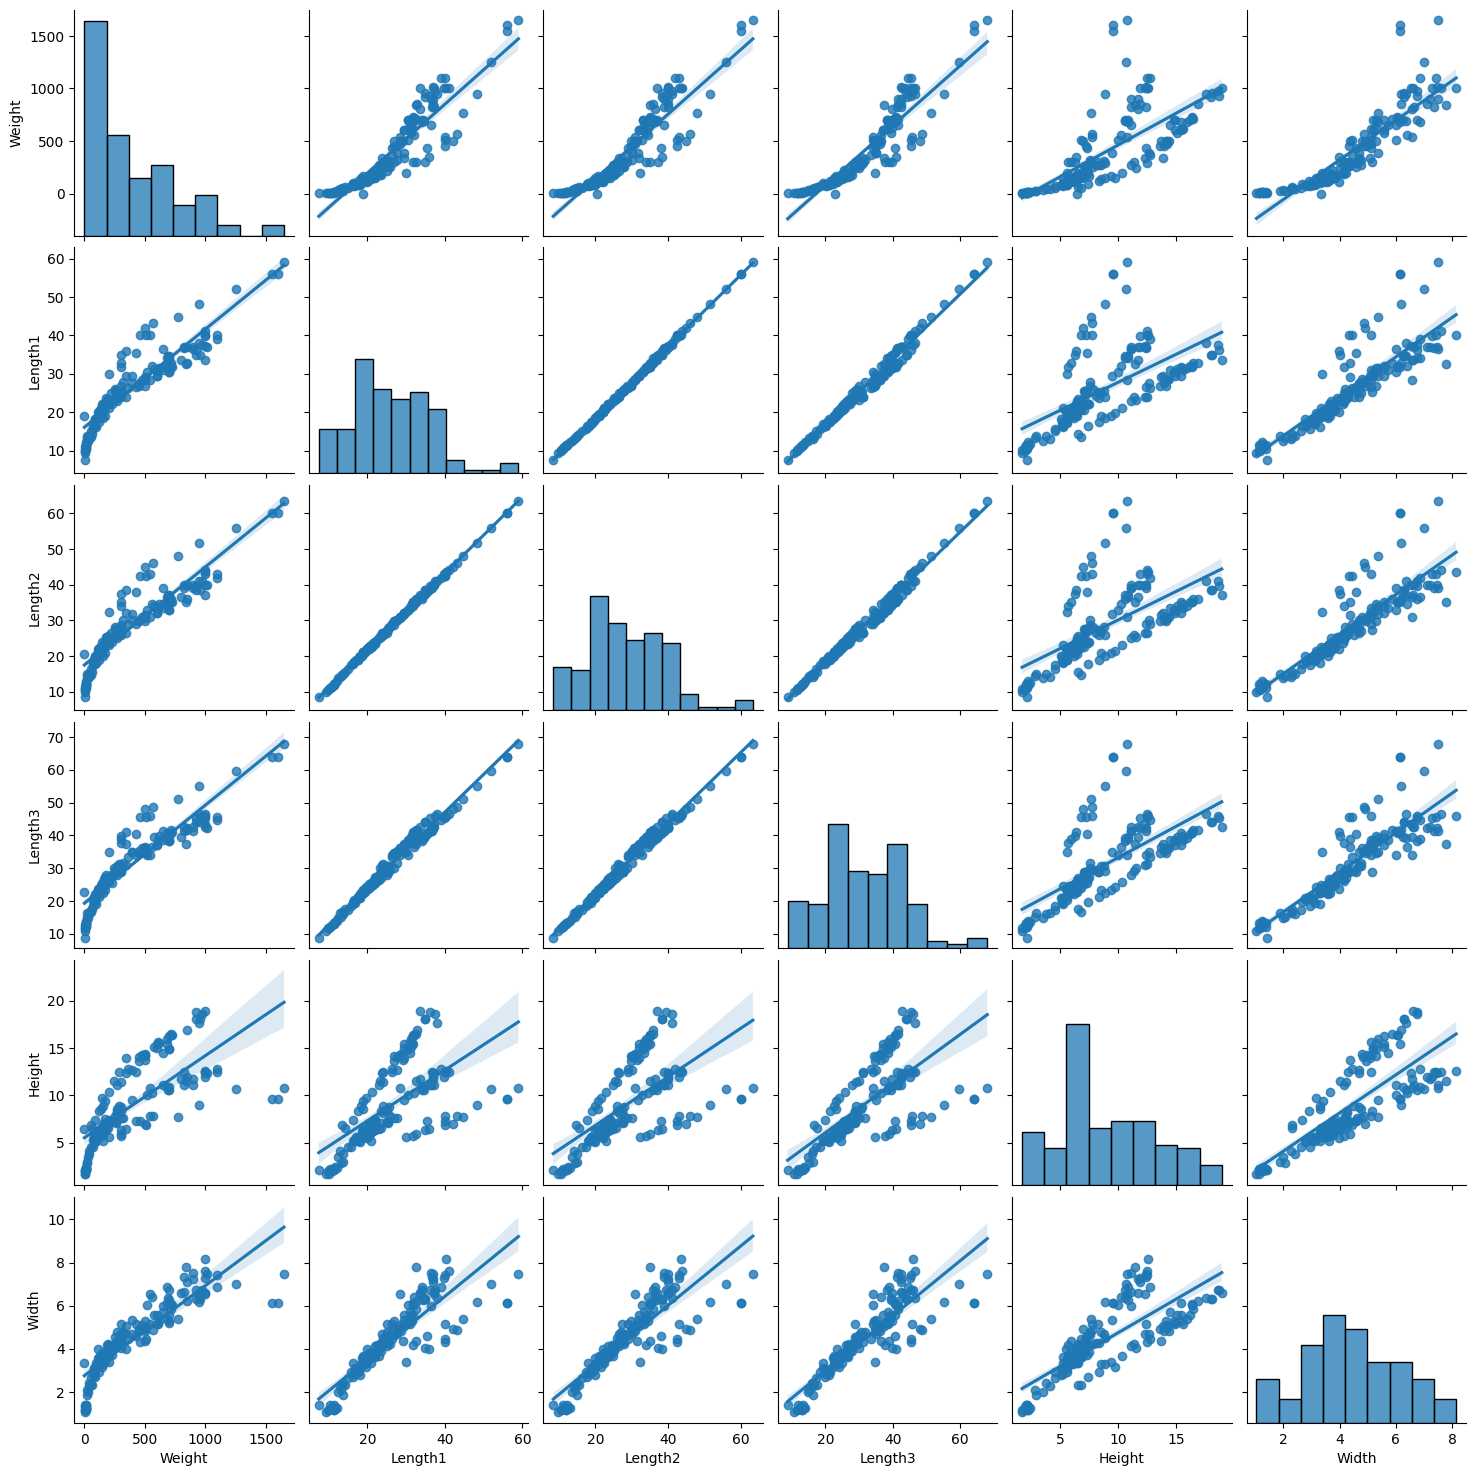

In [ ]:
import seaborn as sns


data = pd.read_csv('Fish.csv')
sns.pairplot(data = data, kind = 'reg', diag_kind = 'auto')
plt.show()

# Hint: Используйте sns.pairplot, его мы рассматривали на семинаре

> Сильно ли изменились результаты? Если да, то для каких конкретно переменных? - Результаты чего?

Проверим гипотезы о нормальном распределении

In [ ]:
from scipy.stats import kstest, norm, pearsonr


for column in data[variables]:

    random_variable = data[column]

    mean = np.mean(random_variable)
    std = np.std(random_variable)
    theoretical_distribution = norm(loc=mean, scale=std)

    statistic, p_value = kstest(random_variable, theoretical_distribution.cdf)

    print(f"Значения параметров нормального распределения случайной величины {column}: {mean}, {std}")
    print(f"P-значение: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print(f"Гипотеза о нормальном распределении {column} отклоняется.")
    else:
        print(f"Гипотеза о нормальном распределении {column} принимается.")

    print('\n')

Значения параметров нормального распределения случайной величины Length1: 26.247169811320756, 9.964956278140518
P-значение: 0.3959225403554635
Гипотеза о нормальном распределении Length1 принимается.


Значения параметров нормального распределения случайной величины Length2: 28.415723270440253, 10.68257580056147
P-значение: 0.4142428388716072
Гипотеза о нормальном распределении Length2 принимается.


Значения параметров нормального распределения случайной величины Length3: 31.227044025157234, 11.573678038449335
P-значение: 0.3435162793586344
Гипотеза о нормальном распределении Length3 принимается.


Значения параметров нормального распределения случайной величины Height: 8.970993710691824, 4.2727077199165695
P-значение: 0.016236686860181808
Гипотеза о нормальном распределении Height отклоняется.


Значения параметров нормального распределения случайной величины Width: 4.417485534591195, 1.6804942383152874
P-значение: 0.5949738743434563
Гипотеза о нормальном распределении Width принимае

Гипотеза о нормальном распределении была отклонена для `Height`, хотя значение достаточно близко к пороговому. Однако мы всё же будем считать, что `Height` распределена нормально. Поскольку из гистограмм видно, что проблемы могло вызвать лишь распределение `Height` для `Parkki`. Для остальных же видов рыб гистограммы схожи с "колоколом" нормального распределения.

Другая проблема у нас возникает с нашей целевой переменной -- `Weight`. Проверим гипотезу о нормальном распределении для каждого конкретного вида рыбы

In [ ]:
for specie in species:

    random_variable = data[data['Species'] == specie][target]

    mean = np.mean(random_variable)
    std = np.std(random_variable)
    theoretical_distribution = norm(loc=mean, scale=std)

    statistic, p_value = kstest(random_variable, theoretical_distribution.cdf)

    print(f"Значения параметров нормального распределения случайной величины Weight для {specie}: {mean}, {std}")
    print(f"P-значение: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print(f"Гипотеза о нормальном распределении Weight для {specie} отклоняется.")
    else:
        print(f"Гипотеза о нормальном распределении Weight для {specie} принимается.")

    print('\n')

Значения параметров нормального распределения случайной величины Weight для Bream: 617.8285714285714, 206.19539771977531
P-значение: 0.6893969429054044
Гипотеза о нормальном распределении Weight для Bream принимается.


Значения параметров нормального распределения случайной величины Weight для Bream: 617.8285714285714, 206.19539771977531
P-значение: 0.6893969429054044
Гипотеза о нормальном распределении Weight для Bream принимается.


Значения параметров нормального распределения случайной величины Weight для Bream: 617.8285714285714, 206.19539771977531
P-значение: 0.6893969429054044
Гипотеза о нормальном распределении Weight для Bream принимается.


Значения параметров нормального распределения случайной величины Weight для Bream: 617.8285714285714, 206.19539771977531
P-значение: 0.6893969429054044
Гипотеза о нормальном распределении Weight для Bream принимается.


Значения параметров нормального распределения случайной величины Weight для Bream: 617.8285714285714, 206.19539771977531

Таким образом, гипотеза отклоняется толкьо для `Perch`. Следовательно, вопреки отклонению гипотезы о нормальном распределении для неоднородного случая, мы будем считать, что целевая переменная Weight в целом распределена нормально.

Напоследок разберемся с истинной корреляцией. Рассмотрим гипотезу о нулевой корреляции между фичами и таргетом. Здесь мы будем рассматривать эти гипотезы для неоднородного случая (то есть не разделяя рыб по видам).

In [ ]:
import numpy as np
from scipy.stats import pearsonr

alpha = 0.05
target_name = 'Weight'

numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(target_name)

for feature in numeric_cols:
    x = data[feature]
    y = data[target_name]

    statistic, p_value = pearsonr(x, y)

    # Н_0 - гипотеза об отсутстви корреляции фичи с таргетом

    print(f"P-значение: {p_value}, {statistic} ")
    print()

    if p_value < alpha:
        print(f"Гипотеза H_0 для {column} и {feature} отклоняется.")
    else:
        print(f"Гипотеза H_0 для {column} и {feature} принимается.")



P-значение: 4.749619722768397e-64, 0.915711716031204 

Гипотеза H_0 для Weight и Length1 отклоняется.
P-значение: 3.3951132290318345e-65, 0.9186177013642216 

Гипотеза H_0 для Weight и Length2 отклоняется.
P-значение: 5.023191454303646e-67, 0.9230435593620121 

Гипотеза H_0 для Weight и Length3 отклоняется.
P-значение: 3.8423418389517914e-27, 0.7243453291993318 

Гипотеза H_0 для Weight и Height отклоняется.
P-значение: 2.038194641185359e-54, 0.8865066052433448 

Гипотеза H_0 для Weight и Width отклоняется.


> Таким образом, для каких фичей мы можем считать корреляцию нулевой?

Исключим из data те фичи, для которых корреляция нулевая и построим корреляционную матрицу

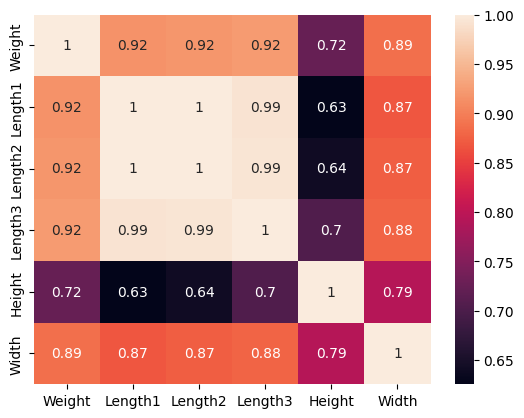

In [ ]:
import seaborn as sns

# удалим категориальный признак
copy_data = data.copy()
copy_data = copy_data.drop(columns = 'Species')

sns.heatmap(copy_data.corr(), annot=True)
plt.show()


Перед построением модели у нас осталась одна последняя неразрешенная проблема: в нашем датасете присутствует категориальный текстовый признак Species. Нам нужно закодировать его с помощью чисел.
В качестве простейшего способа кодирования будем использовать One-Hot-Encoding

In [ ]:

data_encoded = pd.get_dummies(data, columns = ['Species'], prefix= 'Species', dtype = int, drop_first = True)
print(data_encoded.head())

# Борьба с мультиколинеарностью:


# Hint: самостоятельно найдите способ правильно преобризовать Species.
# Hint: можете почитать про get_dummies в Pandas или OneHotEncoder в sklearn
# Hint: учитывайте, что категориальный признак вида:      sex
#                                                         man
#                                                         man
#                                                         woman
# создаст две one-hot фичи
#                                                         sex_man sex_woman
#                                                         1       0
#                                                         1       0
#                                                         0       1
# это может вызвать проблему мультиколлинеарности признаков. поэтому заранее предусмотрите этот момент. и за ненадобностью можно удалить один из one-hot признаков,
# чтобы получилось
#                                                         sex_man
#                                                         1
#                                                         1
#                                                         0
# то есть один оставшийся признак несет в себе достаточно ифнормации о том, какого пола объект

   Weight  Length1  Length2  Length3   Height   Width  Species_Parkki  \
0   242.0     23.2     25.4     30.0  11.5200  4.0200               0   
1   290.0     24.0     26.3     31.2  12.4800  4.3056               0   
2   340.0     23.9     26.5     31.1  12.3778  4.6961               0   
3   363.0     26.3     29.0     33.5  12.7300  4.4555               0   
4   430.0     26.5     29.0     34.0  12.4440  5.1340               0   

   Species_Perch  Species_Pike  Species_Roach  Species_Smelt  \
0              0             0              0              0   
1              0             0              0              0   
2              0             0              0              0   
3              0             0              0              0   
4              0             0              0              0   

   Species_Whitefish  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


## Построение модели линейной регресии

Сперва обозначим всю выборку через $X$ (фичи) и $y$ (таргет)

In [ ]:
X = data_encoded.drop(columns='Weight')
y = data_encoded[target]

Приведем $X$ и $y$ к стандартному виду (среднее = 0, среднеквадратичное отклонение = 1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)
y = scaler.fit_transform(pd.DataFrame(y))

Убедимся в том, что все данные были преобразованы как надо

In [ ]:

data_encoded.describe()
# Hint: имеется в виду метод .describe()

,Weight,Length1,Length2,Length3,Height,Width,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486,0.069182,0.352201,0.106918,0.125786,0.088050,0.037736
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804,0.254566,0.479165,0.309986,0.332656,0.284263,0.191159
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


from matplotlib import pyplot as plt
_df_0['Weight'].plot(kind='hist', bins=20, title='Weight')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Length1'].plot(kind='hist', bins=20, title='Length1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Length2'].plot(kind='hist', bins=20, title='Length2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Length3'].plot(kind='hist', bins=20, title='Length3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Weight', y='Length1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Length1', y='Length2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Length2', y='Length3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Length3', y='Height', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Weight'].plot(kind='line', figsize=(8, 4), title='Weight')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Length1'].plot(kind='line', figsize=(8, 4), title='Length1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Length2'].plot(kind='line', figsize=(8, 4), title='Length2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Length3'].plot(kind='line', figsize=(8, 4), title='Length3')
plt.gca().spines[['top', 'right']].set_visible(False)

Разделим всю выборку на train и test наборы

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state= 42)

Теперь воспользуемся уже готовой реализацией модели линейной регрессии из библиотеки sklearn

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

Обучим модель на train выборке

In [ ]:
lr.fit(X_train, y_train)

LinearRegression()

Рассмотрим значения метрик $MSE$ и $R^2$ на тестовом наборе

In [ ]:
from os import pread
from sklearn.metrics import mean_squared_error, r2_score

y_hat = lr.predict(X_train)
# Hint: вычислите прогнозы модели на обучающем наборе

train_mse = mean_squared_error(y_train, y_hat)
train_r2 = r2_score(y_train, y_hat)

print(f'Значение MSE на Train наборе {train_mse}')
print(f'Значение R^2 на Train наборе {train_r2}')

Значение MSE на Train наборе 0.07028917235403295
Значение R^2 на Train наборе 0.9290843027261066


> Какие выводы можно сделать о значениях метрик? MSE сильно высокая или принимает умеренные значения?

> О чем свидетельствует значение R^2 ? Адекватна ли модель в смысле R^2 метрики?


Uns: Так как значение метрики R^2 близко к 1, то построенная модель точно повторила корреляцию в данных

Теперь рассмотрим значения метрик на тестовом наборе

In [ ]:
y_pred = lr.predict(X_test)
# Hint: вычислите прогнозы модели на тестовом наборе

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f'Значение MSE на Test наборе {test_mse}')
print(f'Значение R^2 на Test наборе {test_r2}')

Значение MSE на Test наборе 0.052940491664053436
Значение R^2 на Test наборе 0.9482958230393607


> Какие выводы можно сделать о значениях метрик на тестовом наборе относительно метрик на обучающемся наборе? - построенная модель одинаково хороошо (близко к 1) сохраняет точность как на тренировочных данных, и данных, которые не видела.

> Что можно сказать о переобучении? (т.е. метрики на тестовом наборе сильно выше, чем на тестовом?) - (т.е. метрики на тренировочном наборе сильно выше, чем на тестовом?) - скорее так правильно. Метрика на тестовом наборе выше, чем на тренировчном

> Если возникло переобучение, то как можно было бы избавиться от него? - можно было бы начать штрафовать модель при помощи регуляризации

Завернём вычисление метрик в одну функцию

In [ ]:
def metrics(y_train, y_hat, y_test, y_pred):

    train_mse = mean_squared_error(y_train, y_hat)
    train_r2 = r2_score(y_train, y_hat)

    print(f'Значение MSE на Train наборе {train_mse}')
    print(f'Значение R^2 на Train наборе {train_r2}')

    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    print(f'Значение MSE на Test наборе {test_mse}')
    print(f'Значение R^2 на Test наборе {test_r2}')

## Модели с регуляризацией: Ridge и LASSO

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

### Ridge

Сперва рассмотрим результаты применения Ridge регрессии, то есть L2 регуляризации.

Зададим сетку параметров

In [ ]:
ridge_params = {'alpha': np.logspace(-3, 3, 50)}
ridge_params

{'alpha': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
        3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
        9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
        2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
        9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
        2.81176870e-01, 3.72759372e-01, 4.94171336e-01, 6.55128557e-01,
        8.68511374e-01, 1.15139540e+00, 1.52641797e+00, 2.02358965e+00,
        2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
        8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
        2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
        7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
        2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
        7.54312006e+02, 1.00000000e+03])}

То есть под сеткой параметров понимается множество из 50 точек от $10^{-3}$ до $10^3$. Шаг между узлами (т.е. точками) сетки метод `np.logspace` подбирает автоматически.

Далее создадим объект Ridge регрессии

In [ ]:
ridge = Ridge()

Теперь мы будем подбирать наилучшее значение для параметра с помощью кросс-валидации.

GridSearchCV позволяет запускать кросс-валидацию, выбирая последовательно каждое из значений параметра на сетке и подставляя его.

В этом алгоритме можно указывать
- cv : различные значения разбиений на fold-ы,
- scroing : различные метрики (в нашем случае `neg_mean_squared_error` - это MSE, `r2` - это R^2),
- verbose : различный формат вывода информации.

Затем мы запускаем fit в этой модели, чтобы прогнать кросс-валидацию по всей сетке

In [ ]:
ridge_cv = GridSearchCV(ridge, # модель
                        param_grid=ridge_params, # сетка параметров
                        cv=5, # к оличество fold-ов (разбиений) в кросс-валидации
                        scoring='neg_mean_squared_error', # метрика, которую мы минимизируем в кросс-валидации
                        verbose= 3 # параметр равный 1, 2 или 3, который отвечает за выводимую информацию (можете самостоятельно покрутить его и посмотреть)
                       )

ridge_cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .......................alpha=0.001;, score=0.941 total time=   0.0s
[CV 2/5] END .......................alpha=0.001;, score=0.927 total time=   0.0s
[CV 3/5] END .......................alpha=0.001;, score=0.908 total time=   0.0s
[CV 4/5] END .......................alpha=0.001;, score=0.887 total time=   0.0s
[CV 5/5] END .......................alpha=0.001;, score=0.873 total time=   0.0s
[CV 1/5] END .......alpha=0.0013257113655901094;, score=0.941 total time=   0.0s
[CV 2/5] END .......alpha=0.0013257113655901094;, score=0.927 total time=   0.0s
[CV 3/5] END .......alpha=0.0013257113655901094;, score=0.908 total time=   0.0s
[CV 4/5] END .......alpha=0.0013257113655901094;, score=0.887 total time=   0.0s
[CV 5/5] END .......alpha=0.0013257113655901094;, score=0.874 total time=   0.0s
[CV 1/5] END .......alpha=0.0017575106248547913;, score=0.941 total time=   0.0s
[CV 2/5] END .......alpha=0.0017575106248547913

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2....
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])},
             scoring='r2', verbose=3)

Внутри модели все значения score отсортировываются, поэтому мы сразу можем вывести наилучшее значение для регуляризационного параметра (то есть при котором минимальное значение минимизируемой метрики)

In [ ]:
print("Лучшее значение alpha для Ridge:", ridge_cv.best_params_)

Лучшее значение alpha для Ridge: {'alpha': np.float64(2.023589647725158)}


Также мы можем сразу получить модель, с подставленным наилучшим значением `alpha`:

In [ ]:
best_ridge = ridge_cv.best_estimator_
best_ridge

Ridge(alpha=np.float64(2.023589647725158))

То есть в `best_ridge` записана наилучшая Ridge регрессия в смысле регуляризационного коэффициента `alpha`. Расчитаем все метрики для этой модели

In [ ]:
y_hat = best_ridge.predict(X_train)
y_pred = best_ridge.predict(X_test)

In [ ]:
metrics(y_train, y_hat, y_test, y_pred)

Значение MSE на Train наборе 0.07362525067720677
Значение R^2 на Train наборе 0.9257184881557403
Значение MSE на Test наборе 0.05495329202108097
Значение R^2 на Test наборе 0.9463300274342388


> Сравните получившиеся значения метрик. В каком случае метрики лучше: в классической LinearRegression или в Ridge? Значения без Ridge регуляризации:
Значение MSE на Train наборе 0.07028917235403295
Значение R^2 на Train наборе 0.9290843027261066
Можно сделать вывод, исходя из численных результатов, что модель улучшилась незначительно.

> Попробуйте поменять метрику кросс-валидации (то есть с MSE на R^2) и сравнить результаты; попробуйте поменять количество разбиений. Uns: при смене метрики на R^2 - получим значение alpha: {'alpha': np.float64(2.023589647725158)} Значения MSE и R^2 поменются незначительно на несколько тысячных.


### LASSO

Проделаем все аналогичные действия теперь для LASSO

In [ ]:
lasso = Lasso(max_iter=10000)  # Увеличиваем max_iter, чтобы избежать проблем с сходимостью

lasso_params = {'alpha': np.logspace(-3, 3, 50)}

lasso_cv = GridSearchCV(lasso, # модель
                        param_grid=lasso_params, # сетка параметров
                        cv=5, # к оличество fold-ов (разбиений) в кросс-валидации
                        scoring='neg_mean_squared_error', # метрика, которую мы минимизируем в кросс-валидации
                        verbose= 3 # параметр равный 1, 2 или 3, который отвечает за выводимую информацию (можете самостоятельно покрутить его и посмотреть)
                       )

# 2) Запускаем поиск (fit)
lasso_cv.fit(X_train, y_train)

# 3) Теперь можно обращаться к результатам
print("----------------------")
print("Лучшие параметры: ", lasso_cv.best_params_)
best_lasso = lasso_cv.best_estimator_

# 4) Строим предсказания и считаем метрики
y_hat  = best_lasso.predict(X_train)
y_pred = best_lasso.predict(X_test)
metrics(y_train, y_hat, y_test, y_pred)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ......................alpha=0.001;, score=-0.053 total time=   0.0s
[CV 2/5] END ......................alpha=0.001;, score=-0.085 total time=   0.0s
[CV 3/5] END ......................alpha=0.001;, score=-0.081 total time=   0.0s
[CV 4/5] END ......................alpha=0.001;, score=-0.157 total time=   0.0s
[CV 5/5] END ......................alpha=0.001;, score=-0.058 total time=   0.0s
[CV 1/5] END ......alpha=0.0013257113655901094;, score=-0.053 total time=   0.0s
[CV 2/5] END ......alpha=0.0013257113655901094;, score=-0.085 total time=   0.0s
[CV 3/5] END ......alpha=0.0013257113655901094;, score=-0.080 total time=   0.0s
[CV 4/5] END ......alpha=0.0013257113655901094;, score=-0.156 total time=   0.0s
[CV 5/5] END ......alpha=0.0013257113655901094;, score=-0.057 total time=   0.0s
[CV 1/5] END ......alpha=0.0017575106248547913;, score=-0.053 total time=   0.0s
[CV 2/5] END ......alpha=0.0017575106248547913;

> Сравните получившиеся значения метрик. В каком случае метрики лучше: в классической LinearRegression, Ridge или LASSO?

> Попробуйте поменять метрику кросс-валидации (то есть с MSE на R^2) и сравнить результаты; попробуйте поменять количество разбиений

## Полиномиальные регрессии

Вернемся к диаграммам рассеяния по видам и можем увидеть, что, например, для рыб вида `Pike`, взаимосвязь между `Weight` и фичами не совсем линейная, а немного кривая. Поэтому мы можем попробовать аппроксимировать взаимосвязь не линейной функцией
$$
f(x,w) = (x,w),
$$
а квадратичной
$$
f(x,w, w) = (x,w) + (x^2, w')
$$
или кубической. Тогда появляется один дополнительный вектор параметров $w' \in \mathbb R^m$. То есть параметров для оценки становится больше, модель становится сложнее, но результаты могут оказаться лучше.

Попробуем добавить признаки 2-ой, 3-ей и 4-ой степеней в модель

In [ ]:
degrees = [2, 3, 4]

for degree in degrees:
    # Создаём пайплайн: сначала преобразуем полиномиальные признаки, затем применяем линейную регрессию

    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('linear_regression', LinearRegression())
    ])

    # Обучение модели
    model.fit(X_train, y_train)

    # Значения метрик
    print(f'Метрики в случае полиномиальных признаков {degree} порядка')

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics(y_train, y_train_pred, y_test, y_test_pred)
    print('_______________________________________________')

Метрики в случае полиномиальных признаков 2 порядка
Значение MSE на Train наборе 0.0086637658213789
Значение R^2 на Train наборе 0.9912590094083593
Значение MSE на Test наборе 0.04095733055943369
Значение R^2 на Test наборе 0.9599991424235628
_______________________________________________
Метрики в случае полиномиальных признаков 3 порядка
Значение MSE на Train наборе 8.248778582688154e-05
Значение R^2 на Train наборе 0.9999167769564986
Значение MSE на Test наборе 2420.071121943571
Значение R^2 на Test наборе -2362.5554112404493
_______________________________________________
Метрики в случае полиномиальных признаков 4 порядка
Значение MSE на Train наборе 8.248778582688155e-05
Значение R^2 на Train наборе 0.9999167769564986
Значение MSE на Test наборе 261.39348907669125
Значение R^2 на Test наборе -254.28918963094864
_______________________________________________


> Сравните получившиеся значения метрик. В каком случае метрики лучше ?

> Происходит ли переобучение? Если да, то с какой степени полиномов модель будет переобучаться? Если нет, то попробуйте добавить степени полиномов и посмотреть, что получится Uns: модель начинает переобучаться с политнома степмени 3


## Выводы

Таким образом, лучшей моделью для решения задачи прогнозирования веса рыбы является модель линейной регрессии c Ridge

Она имеет следующие метрики:
- На Обучающем наборе
- - $MSE$ : 0.07362525067720677
  - $R^2$ : 0.9257184881557403
- На Тестовом наборе
- - $MSE$ : 0.05495329202108097
  - $R^2$ : 0.9463300274342388



> В качестве доп. задания рекомендуется также исследовать значимость коэффициентов моделей и поведение остатков моделей. Сделайте соответствующие выводы